In [152]:
##########################Load Libraries  ####################################
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt


import random 

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torchinfo import summary
import pandas as pd
import os

from tqdm import trange
import inspect
import time
%matplotlib inline

from myUtils import *
from plottingUtils import *

In [153]:
#hyperparameters

data_dir = "./datasets/PJM_power/"
fname = "DAYTON_hourly.csv"

sample_len = 240
step = 1
target_len = 120
batch_size = 64
steps_in_day = 24

HID_DIM = 64
N_LAYERS = 2
DROPOUT = 0.5
N_SINS = 20
N_PARAMS = 2 + 3*N_SINS

desired_features = None

In [154]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))
print(torch.__version__)

Using cuda device
2.0.1+cu117


In [155]:
def apply_vals(vals, seq):
    '''
    vals: [batch size, n_features, n_params]
    
    '''
    batch_size = vals.shape[0]
    n_features = vals.shape[1]
    vals = vals.unsqueeze(3)
    #print("vals", vals.shape, vals.device)
    seq = seq.unsqueeze(0).unsqueeze(1).repeat(batch_size, n_features, 1).float()
    #print("seq", seq.shape, seq.device)
    #print("x0", vals[:,:,0].shape)
    #print("a", vals[:,:,2::2].shape)
    x =  vals[:,:, 3::3] + torch.matmul(vals[:,:, 4::3], seq.unsqueeze(2))
    #print("x", x.shape)
    #print("a", vals[:,:,2::3].shape)
    out = vals[:,:,0] + vals[:,:,1] * seq + (vals[:,:, 2::3] * torch.sin(x)).sum(2)
    #print("out", out.shape)
    return out.permute(0, 2, 1)


In [156]:
class Fourier(nn.Module):
    def __init__(self, n_features, hid_dim, n_layers, n_params, dropout, device):
        super().__init__()

        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.device = device

        self.rnn = nn.GRU(
            input_size=n_features,
            hidden_size=hid_dim,
            num_layers=n_layers,
            dropout=dropout,
            batch_first=True,
        )

        self.fc = nn.Linear(hid_dim * n_layers, n_params * n_features)

    def forward(self, src):
        # src = [batch size, src len, n features]
        #print("src", src.shape)
        batch_size = src.shape[0]
        n_features = src.shape[2]
        
        _, hidden = self.rnn(src)
        #hidden = [n layers, batch size, hid dim]
        hidden = hidden.permute(1, 0, 2).reshape(batch_size, -1).contiguous()
        #hidden = [batch size, n layers * hid dim]
        output = self.fc(hidden)
        #output = [batch size, n params * n features]
        return output.reshape(batch_size, n_features, -1)

In [157]:
# model fitting



def train(
    dataloader,
    model,
    loss_fn,
    optimizer,
    iter_count=None,
    visibility=True,
):
    """
    dataloader: iterable
    model: model to train
    loss_fn: loss function
    optimizer: used optimizer
    iter_count: number of iterations, if None then dataloader length
    desired_features: list of features to be used in loss calculation, if None then all features
    teacher_forcing_ratio: probability to use teacher forcing
    visibility: boolean, if True then show progress bar
    """
    assert not (
        inspect.isgenerator(dataloader) and iter_count is None
    ), "generator must have specified size"
    if iter_count is None:
        iter_count = len(dataloader.dataset)

    data_iterator = iter(dataloader)
    model.train()
    average_loss = 0

    r = trange(iter_count) if visibility else range(iter_count)

    for _ in r:
        x, y = next(data_iterator)
        x, y = x.to(device), y.to(device)
        # y = y.unsqueeze(1).to(torch.float)
        # Compute prediction error

        pred = model(x)
        value = apply_vals(pred, torch.arange(y.shape[1]).to(device))
        
        loss = loss_fn(value, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        average_loss += loss.item()

    average_loss /= iter_count

    return average_loss


def eval(
    dataloader, 
    model, 
    loss_fn, 
    iter_count=None, 
    visibility=True
):
    """
    dataloader: iterable
    model: model to train
    loss_fn: loss function
    iter_count: number of iterations, if None then dataloader length
    desired_features: list of features to be used in loss calculation
    visibility: boolean, if True then show progress bar
    """
    if iter_count is None:
        iter_count = len(dataloader.dataset)
    data_iterator = iter(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        r = trange(iter_count) if visibility else range(iter_count)
        for _ in r:
            x, y = next(data_iterator)
            x, y = x.to(device), y.to(device)
            # y = y.unsqueeze(1).to(torch.float)
            pred = model(x)
            value = apply_vals(pred, torch.arange(y.shape[1]).to(device))

            test_loss += loss_fn(value, y).item()

    test_loss /= iter_count

    return test_loss


def fit_model(
    model,
    train_dataloader,
    val_dataloader,
    loss_fn,
    optimizer,
    scheduler,
    epochs=5,
    train_iter_count=None,
    val_iter_count=None,
    visibility = 0,
    save_model = False
):
    '''
    model: model to train
    train_dataloader: iterable
    val_dataloader: iterable
    loss_fn: loss function
    optimizer: used optimizer
    epochs: number of epochs
    train_iter_count: number of training iterations
    val_iter_count: number of validation iterations
    desired_features: list of features to be used in loss calculation
    teacher_forcing_ratio: probability to use teacher forcing
    visibility: 0 - no progress bar, 1 - progress bar for entire training, 2 - progress bar for each epoch
    save_model: boolean, if True then save model with lowest validation loss
    '''
    history = {
        "train": {"loss": []},
        "val": {"loss": []},
    }
    total_time_start = time.time()
    r = trange(epochs) if visibility == 1 else range(epochs)

    min_val_loss = np.inf

    for t in r:
        if visibility == 2:
            print(f"Epoch {t+1}\n-------------------------------")
            print("Test")
        train_loss = train(
            train_dataloader,
            model,
            loss_fn=loss_fn,
            optimizer=optimizer,
            iter_count=train_iter_count,
            visibility=(visibility == 2),
        )
        if visibility == 2:
            print("Eval")
        test_loss = eval(
            val_dataloader,
            model,
            loss_fn=loss_fn,
            iter_count=val_iter_count,
            visibility=(visibility == 2),
        )

        scheduler.step(test_loss)

        if min_val_loss > test_loss and save_model:
            min_val_loss = test_loss
            torch.save(model, "model.pth")
        if visibility == 2:
            print(f"Train Error: Avg loss: {train_loss:>8f} ")
            print(f"Test Error: Avg loss: {test_loss:>8f} \n")
        history["train"]["loss"].append(train_loss)
        history["val"]["loss"].append(test_loss)

    total_time_end = time.time()
    total_duration = total_time_end - total_time_start
    
    average_duration = total_duration / epochs
    if visibility != 0:
        print(f"Total Duration: {print_duration(total_duration)}")
        print(f"Average Duration: {print_duration(average_duration)}")

    
    return history

In [158]:
# preprocessing


df = extract_dataframe(data_dir, fname)
#df = add_features(df, steps_in_day=steps_in_day)

header, float_data = extract_data(df)
normalized_data, mean, std = normalize_data(float_data)

In [159]:
timesteps = len(float_data)
print(f'{timesteps} timesteps')

121275 timesteps


In [160]:

train_max_index = int(timesteps * 0.7)

train_generator = floating_window_batch_generator(
    normalized_data,
    sample_len=sample_len,
    target_len=target_len,
    min_index=0,
    max_index=train_max_index,
    shuffle=True,
    step=step,
    batch_size=batch_size,
    
)

val_generator = floating_window_batch_generator(
    normalized_data,
    sample_len=sample_len,
    target_len=target_len,
    min_index=train_max_index+1,
    max_index=timesteps,
    shuffle=True,
    step=step,
    batch_size=batch_size
)



DAYTON_MW


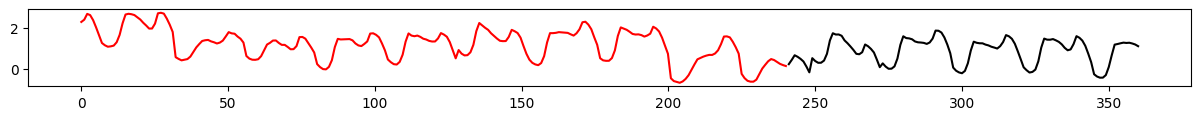

In [161]:
samples, targets = next(train_generator)
for feature in range(samples.shape[-1]):
    print(header[feature])
    plot_samples(samples, targets, feature, figsize=(15,1))

In [162]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)



In [163]:

N_SAMPLES = float_data.shape[1]

model = Fourier(N_SAMPLES, HID_DIM, N_LAYERS, N_PARAMS, DROPOUT, device).to(device)


# init weights

model.apply(init_weights)

#model = Iterative(N_SAMPLES, HID_DIM, N_LAYERS, DROPOUT).to(device)
print(model)

Fourier(
  (rnn): GRU(1, 64, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=128, out_features=62, bias=True)
)


In [164]:


summary(model,input_size=(10, sample_len, N_SAMPLES),col_names=["input_size", "output_size", "num_params", "trainable", "kernel_size"], col_width=15,)

Layer (type:depth-idx)                   Input Shape     Output Shape    Param #         Trainable       Kernel Shape
Fourier                                  [10, 240, 1]    [10, 1, 62]     --              True            --
├─GRU: 1-1                               [10, 240, 1]    [10, 240, 64]   37,824          True            --
├─Linear: 1-2                            [10, 128]       [10, 62]        7,998           True            --
Total params: 45,822
Trainable params: 45,822
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 90.86
Input size (MB): 0.01
Forward/backward pass size (MB): 1.23
Params size (MB): 0.18
Estimated Total Size (MB): 1.43

In [165]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 45,822 trainable parameters


In [166]:
# Fit model

loss_fn = nn.MSELoss()
learning_rate = 1e-2
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10)

history = fit_model(
    model,
    train_dataloader=train_generator,
    train_iter_count=100,
    val_dataloader=val_generator,
    val_iter_count=50,
    loss_fn=loss_fn,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=5,
    save_model=True,
    visibility=2
)

Epoch 1
-------------------------------
Test


100%|██████████| 100/100 [00:01<00:00, 64.57it/s]


Eval


100%|██████████| 50/50 [00:00<00:00, 126.61it/s]


Train Error: Avg loss: 25.978572 
Test Error: Avg loss: 0.895386 

Epoch 2
-------------------------------
Test


100%|██████████| 100/100 [00:01<00:00, 71.52it/s]


Eval


100%|██████████| 50/50 [00:00<00:00, 119.19it/s]


Train Error: Avg loss: 1.002405 
Test Error: Avg loss: 0.776165 

Epoch 3
-------------------------------
Test


100%|██████████| 100/100 [00:01<00:00, 71.47it/s]


Eval


100%|██████████| 50/50 [00:00<00:00, 122.54it/s]


Train Error: Avg loss: 0.896226 
Test Error: Avg loss: 0.772117 

Epoch 4
-------------------------------
Test


100%|██████████| 100/100 [00:01<00:00, 70.09it/s]


Eval


100%|██████████| 50/50 [00:00<00:00, 121.81it/s]


Train Error: Avg loss: 0.865697 
Test Error: Avg loss: 0.828499 

Epoch 5
-------------------------------
Test


100%|██████████| 100/100 [00:01<00:00, 68.10it/s]


Eval


100%|██████████| 50/50 [00:00<00:00, 122.10it/s]

Train Error: Avg loss: 0.869278 
Test Error: Avg loss: 0.773955 

Total Duration: 0:0:9.310
Average Duration: 0:0:1.862


TypeError: 'Axes' object is not subscriptable

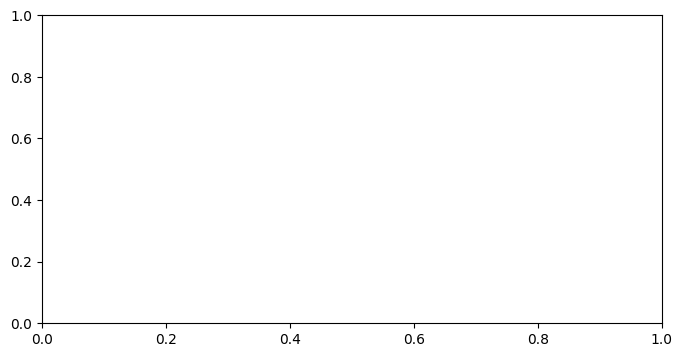

In [167]:
plot_history(history)

In [ ]:


def make_predictions(model, samples, len):
    with torch.no_grad():
        values = model(samples.to(device))
        print(values[0])
        output = apply_vals(values, torch.arange(len).to(device))
    return output





tensor([[-1.6875e-01, -1.2838e-03, -3.6514e-02,  5.0540e-01,  1.0719e-01,
         -1.1584e-01,  5.1405e-01,  3.1675e-02, -1.7042e-02,  6.7525e-01,
          2.7785e-01,  7.0084e-03,  1.4954e-02,  3.9656e-02, -1.9446e-02,
          1.7698e-01,  6.3677e-02,  1.8589e-03,  1.2507e-01, -1.2321e-01,
          3.1102e-03, -3.8441e-01,  1.0464e-01,  3.0263e-02, -4.7730e-01,
         -1.4525e-01,  5.0520e-02,  2.6159e-01,  1.8075e-02, -1.1950e-02,
         -7.4492e-02, -8.6106e-03,  1.0414e-03, -1.3508e-01,  2.0978e-02,
         -3.4573e-02, -1.3398e-01, -2.2121e-02,  5.1548e-02, -3.7802e-01,
         -2.8041e-01,  6.0241e-03,  3.0291e-01,  2.4965e-01,  2.1243e-02,
         -1.8891e-01,  6.3523e-02, -1.8073e-02, -7.3690e-02, -1.7244e-01,
         -1.3574e-02,  2.8302e-01,  1.1653e-01, -2.7179e-02,  4.2321e-01,
         -1.1495e-01, -1.7027e-01,  1.7786e+00, -2.5144e-01,  1.2647e-02,
          1.4984e-01,  1.8503e-01]], device='cuda:0')
torch.Size([64, 120, 1])
DAYTON_MW


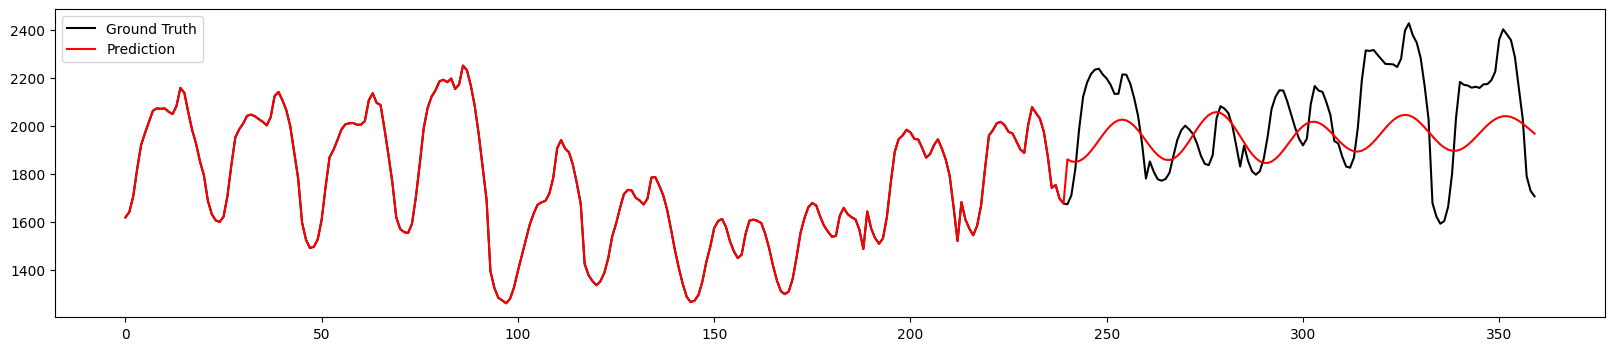

tensor([[ 0.2504,  0.0022,  0.0257,  0.3881,  0.2371, -0.0873,  0.5963, -0.0215,
          0.0312,  0.9830,  0.0865, -0.0028, -0.3420, -0.3248,  0.0405,  0.2729,
          0.1754, -0.0021,  0.2948, -0.1183, -0.0303, -0.6853,  0.0302, -0.0651,
         -0.6598, -0.2622,  0.0235,  0.3059,  0.2671, -0.0204, -0.2997, -0.3175,
          0.0130,  0.1289,  0.2502, -0.0416, -0.4069, -0.4434,  0.1935,  0.4796,
         -0.1689, -0.0369,  0.0058, -0.1334,  0.0256,  0.3802,  0.3901, -0.0058,
          0.1279, -0.0403, -0.0441,  0.0466, -0.0065,  0.0235,  0.5820,  0.2543,
         -0.0167,  1.3347, -0.2200,  0.0173,  0.0332, -0.0178]],
       device='cuda:0')
torch.Size([64, 120, 1])
DAYTON_MW


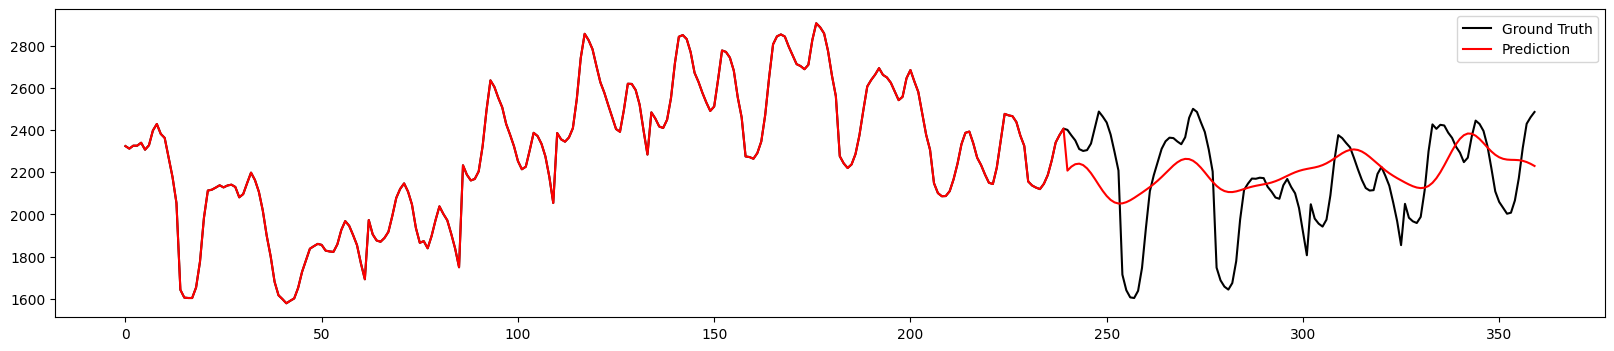

tensor([[ 1.1687e-01,  4.2445e-03,  7.5853e-03,  4.1409e-01,  1.9910e-01,
         -7.1049e-02,  5.5818e-01, -1.3895e-03,  5.1482e-02,  8.9751e-01,
          1.4105e-01, -1.2367e-02, -2.2922e-01, -2.2236e-01,  3.6295e-02,
          2.6580e-01,  1.6083e-01,  2.6469e-02,  2.5274e-01, -1.0771e-01,
         -5.5427e-02, -5.8595e-01,  2.9741e-02, -7.1050e-02, -5.9524e-01,
         -2.3008e-01,  3.6050e-02,  3.1698e-01,  2.1978e-01, -2.7421e-02,
         -2.3565e-01, -2.2341e-01,  1.6584e-02,  5.5577e-02,  1.6216e-01,
         -5.8514e-02, -3.1058e-01, -3.0498e-01,  1.3385e-01,  2.6480e-01,
         -1.7131e-01, -3.0160e-02,  7.3908e-02, -3.1019e-02,  3.4151e-02,
          2.4031e-01,  3.1161e-01, -9.7295e-05,  7.8096e-02, -7.5402e-02,
         -5.0284e-02,  1.0525e-01,  3.5802e-02,  4.1119e-02,  5.0096e-01,
          1.5424e-01,  2.3959e-02,  1.3361e+00, -2.2767e-01,  1.7133e-02,
          8.5101e-02,  5.5557e-02]], device='cuda:0')
torch.Size([64, 120, 1])
DAYTON_MW


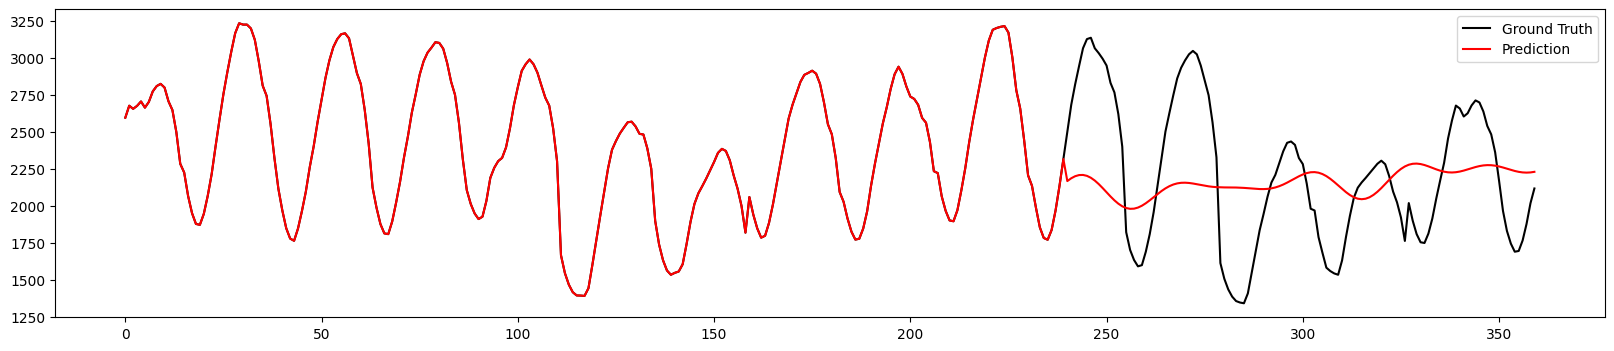

tensor([[-2.7643e-01, -1.4819e-03, -5.3521e-02,  5.4091e-01,  7.5502e-02,
         -1.2224e-01,  4.8588e-01,  3.5849e-02, -3.7821e-02,  5.9183e-01,
          3.3664e-01,  9.6506e-03,  1.1055e-01,  1.5023e-01, -2.5828e-02,
          1.4650e-01,  1.8221e-02, -1.5318e-02,  6.7830e-02, -1.2902e-01,
          3.9697e-02, -2.9422e-01,  1.4000e-01,  7.0643e-02, -4.3266e-01,
         -1.0647e-01,  6.2728e-02,  2.3413e-01, -6.2199e-02, -4.0589e-03,
         -6.6531e-03,  7.4104e-02, -6.3948e-03, -2.0790e-01, -3.9126e-02,
         -2.9984e-02, -6.1377e-02,  9.3768e-02,  1.6761e-02, -6.5553e-01,
         -3.3582e-01,  2.5656e-02,  3.9148e-01,  3.6008e-01,  1.6489e-02,
         -3.6450e-01, -4.4113e-02, -2.6427e-02, -1.3293e-01, -2.1689e-01,
          1.5793e-04,  3.4763e-01,  1.4399e-01, -4.2995e-02,  3.8651e-01,
         -2.2717e-01, -2.8637e-01,  1.9653e+00, -2.6457e-01,  1.3950e-02,
          1.7565e-01,  2.4177e-01]], device='cuda:0')
torch.Size([64, 120, 1])
DAYTON_MW


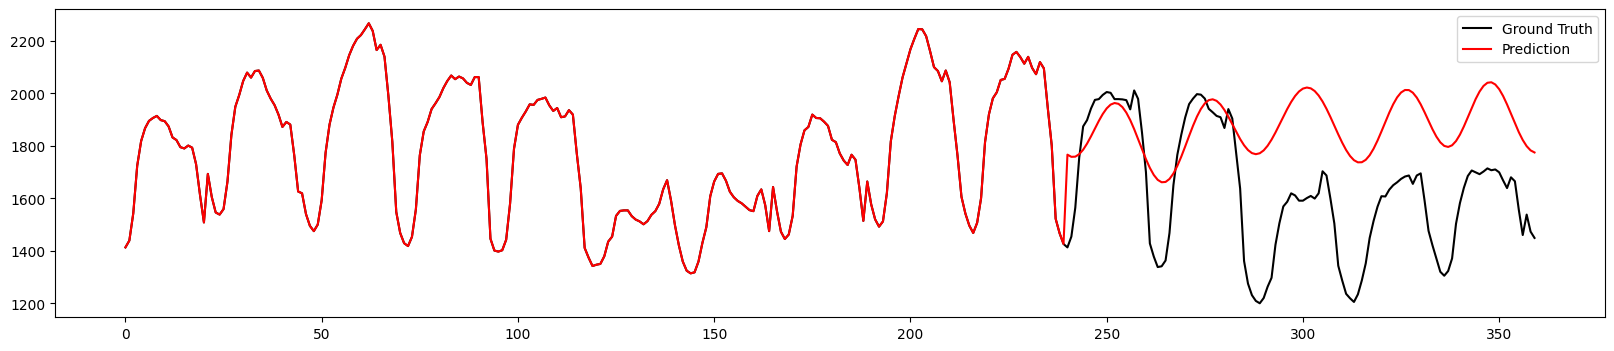

tensor([[-2.6992e-01, -4.3501e-03, -4.8971e-02,  5.2279e-01,  7.1889e-02,
         -1.2329e-01,  5.0618e-01,  6.5540e-02, -1.0979e-02,  6.0632e-01,
          2.9448e-01,  9.6031e-03,  9.5959e-02,  8.8575e-02, -5.6228e-02,
          1.6926e-01,  7.7959e-02,  4.4166e-02,  1.1553e-01, -1.1792e-01,
         -5.2771e-02, -3.4502e-01,  8.0492e-02,  1.7915e-02, -4.2469e-01,
         -1.3142e-01,  4.2355e-02,  2.8428e-01, -4.7088e-03, -2.0702e-02,
         -3.7890e-02,  6.4188e-02,  1.2646e-02, -1.8329e-01, -3.8426e-02,
         -3.5317e-02, -7.6943e-02,  6.4301e-02,  1.4808e-02, -4.5056e-01,
         -2.4669e-01, -9.0221e-03,  3.4528e-01,  3.1544e-01,  2.6887e-02,
         -2.6968e-01,  4.0072e-02, -1.6893e-03, -1.0474e-01, -1.8449e-01,
         -1.9030e-02,  3.3049e-01,  1.5270e-01, -3.0018e-02,  3.6040e-01,
         -1.6624e-01, -3.2685e-02,  1.7134e+00, -2.4448e-01, -4.1822e-03,
          1.9010e-01,  2.2960e-01]], device='cuda:0')
torch.Size([64, 120, 1])
DAYTON_MW


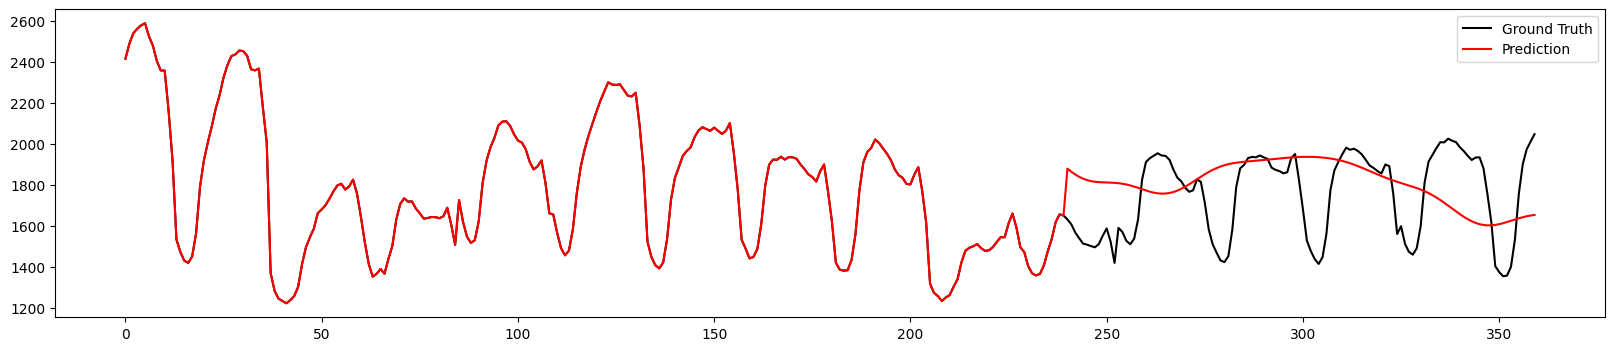

tensor([[ 1.8796e-03, -2.5701e-03, -1.1085e-02,  4.5745e-01,  1.5642e-01,
         -1.1220e-01,  5.5696e-01,  1.9216e-02,  1.3532e-03,  8.0152e-01,
          1.8991e-01,  8.8448e-03, -1.3381e-01, -1.2290e-01, -8.6675e-03,
          2.1663e-01,  1.2342e-01,  1.3041e-02,  2.0644e-01, -1.2064e-01,
         -3.2447e-02, -5.2474e-01,  6.3126e-02, -1.6672e-02, -5.5069e-01,
         -1.9775e-01,  3.1683e-02,  2.8911e-01,  1.2637e-01, -1.8608e-02,
         -1.7455e-01, -1.3509e-01,  8.9192e-03, -2.4918e-02,  1.1814e-01,
         -3.3784e-02, -2.5044e-01, -2.0265e-01,  1.1127e-01,  1.5929e-02,
         -2.1434e-01, -2.1931e-02,  1.7678e-01,  8.7323e-02,  2.4460e-02,
          5.9414e-02,  2.1512e-01, -7.1452e-03,  1.1245e-02, -1.1246e-01,
         -2.8738e-02,  1.8882e-01,  7.0052e-02, -1.3505e-02,  4.8885e-01,
          4.7094e-02, -4.8828e-02,  1.5615e+00, -2.3234e-01,  8.9142e-03,
          1.0405e-01,  9.7179e-02]], device='cuda:0')
torch.Size([64, 120, 1])
DAYTON_MW


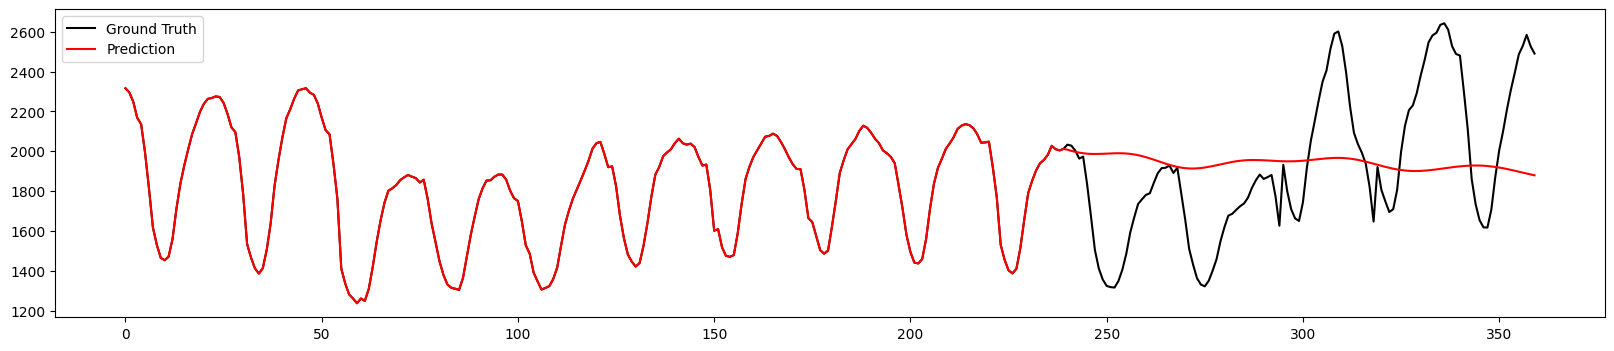

tensor([[-3.2235e-01, -4.4441e-03, -5.7231e-02,  5.4091e-01,  5.6257e-02,
         -1.2864e-01,  4.9305e-01,  6.6561e-02, -2.4470e-02,  5.6535e-01,
          3.2489e-01,  1.2101e-02,  1.4213e-01,  1.4553e-01, -5.8904e-02,
          1.5142e-01,  5.2081e-02,  3.0926e-02,  8.4997e-02, -1.2199e-01,
         -2.9035e-02, -2.9948e-01,  1.0187e-01,  4.2547e-02, -4.0410e-01,
         -1.1099e-01,  4.8828e-02,  2.6680e-01, -4.8693e-02, -1.5401e-02,
         -3.4553e-03,  1.0448e-01,  7.8997e-03, -2.2027e-01, -6.5545e-02,
         -3.0905e-02, -4.2108e-02,  1.2056e-01, -7.4233e-04, -5.9646e-01,
         -2.7930e-01,  2.6300e-03,  3.9090e-01,  3.7099e-01,  2.3703e-02,
         -3.6063e-01, -1.6748e-02, -7.8797e-03, -1.3524e-01, -2.0687e-01,
         -1.0522e-02,  3.6310e-01,  1.6516e-01, -4.0707e-02,  3.4683e-01,
         -2.2383e-01, -1.0667e-01,  1.8242e+00, -2.5243e-01, -2.7424e-03,
          2.0070e-01,  2.5607e-01]], device='cuda:0')
torch.Size([64, 120, 1])
DAYTON_MW


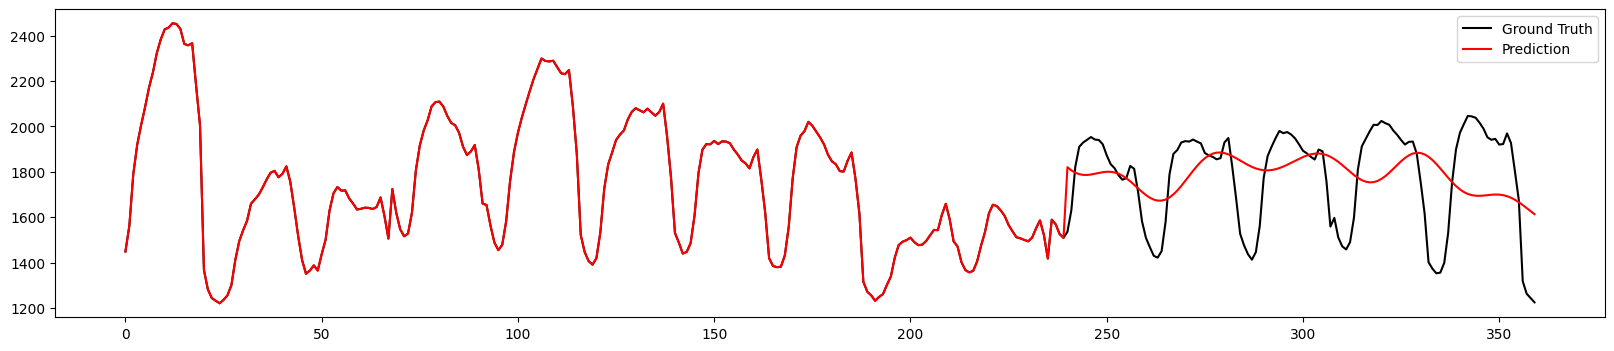

tensor([[ 3.2814e-01,  5.1529e-03,  3.3684e-02,  3.7879e-01,  2.6854e-01,
         -8.2693e-02,  6.0200e-01, -5.1423e-02,  1.8122e-02,  1.0261e+00,
          7.6343e-02, -7.7358e-03, -4.0179e-01, -3.6337e-01,  6.2723e-02,
          2.7686e-01,  1.5819e-01, -3.6249e-02,  3.0120e-01, -1.2224e-01,
          2.2946e-02, -7.1311e-01,  5.2636e-02, -5.1709e-02, -7.0163e-01,
         -2.7821e-01,  2.7779e-02,  2.8657e-01,  2.8337e-01, -1.5204e-02,
         -3.2789e-01, -3.7123e-01,  1.7120e-03,  1.6667e-01,  2.9537e-01,
         -4.0914e-02, -4.5256e-01, -5.0728e-01,  2.2459e-01,  5.2892e-01,
         -2.0051e-01, -1.9757e-02, -2.0527e-02, -1.7736e-01,  1.8738e-02,
          4.3630e-01,  4.0367e-01, -2.1157e-02,  1.4958e-01, -3.2827e-02,
         -3.5267e-02,  1.5458e-02, -3.5005e-02,  2.4346e-02,  6.3257e-01,
          2.9529e-01, -1.2536e-01,  1.3934e+00, -2.2341e-01,  3.2794e-02,
          4.5511e-04, -5.2599e-02]], device='cuda:0')
torch.Size([64, 120, 1])
DAYTON_MW


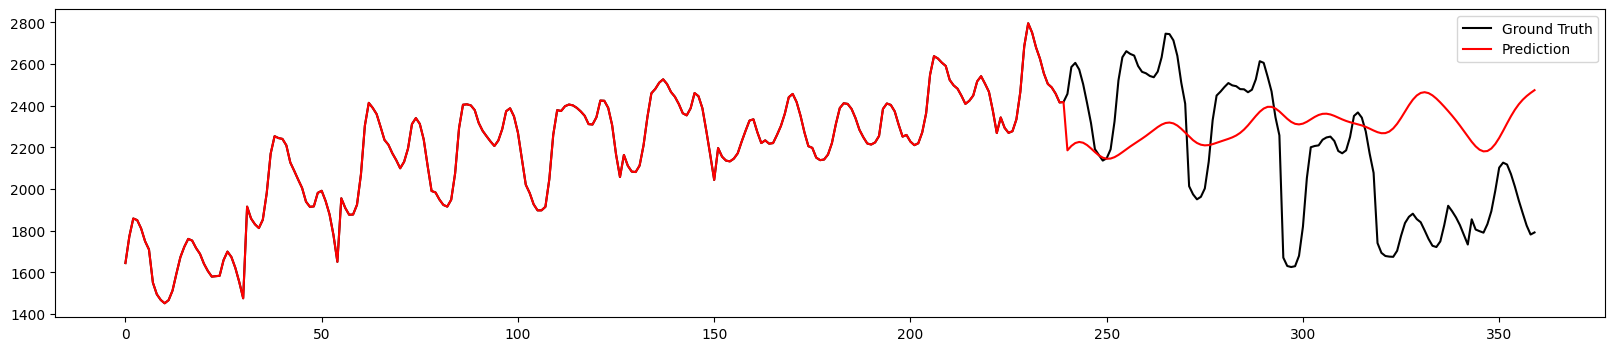

tensor([[ 0.4671,  0.0069,  0.0501,  0.3583,  0.3208, -0.0897,  0.6287, -0.0902,
         -0.0141,  1.0994,  0.0416, -0.0115, -0.5084, -0.4485,  0.0798,  0.2806,
          0.1408, -0.0879,  0.3222, -0.1316,  0.0983, -0.7855,  0.0774, -0.0265,
         -0.7721, -0.3118,  0.0240,  0.2592,  0.3223, -0.0051, -0.3835, -0.4648,
         -0.0119,  0.2367,  0.3823, -0.0291, -0.5440, -0.6350,  0.2868,  0.6683,
         -0.2386, -0.0015, -0.0720, -0.2627,  0.0032,  0.5484,  0.4496, -0.0417,
          0.1950, -0.0088, -0.0169, -0.0412, -0.0849,  0.0117,  0.7221,  0.3828,
         -0.2619,  1.4618, -0.2237,  0.0453, -0.0599, -0.1220]],
       device='cuda:0')
torch.Size([64, 120, 1])
DAYTON_MW


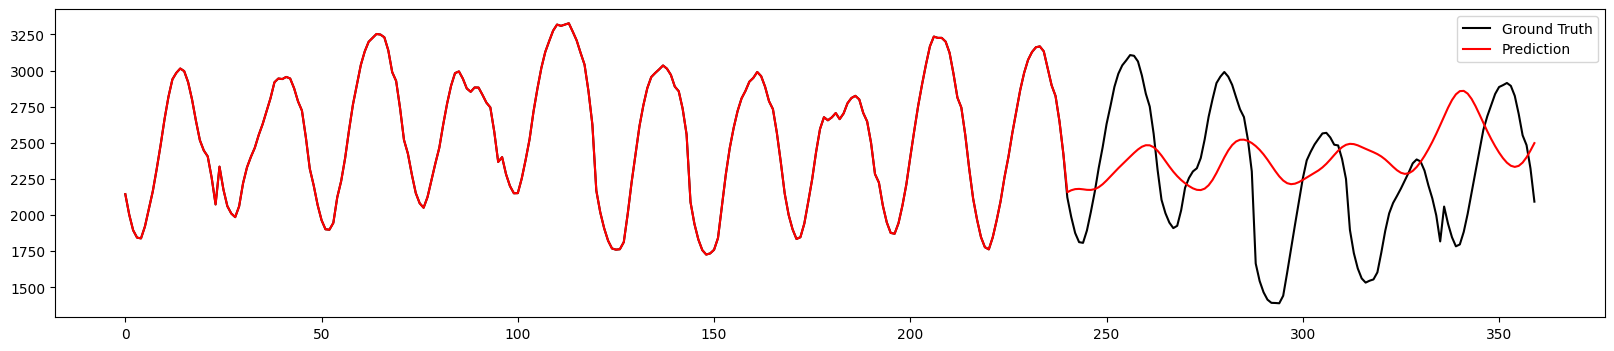

tensor([[ 3.6594e-01,  1.5649e-03,  3.9528e-02,  3.7075e-01,  2.7514e-01,
         -9.4969e-02,  6.1852e-01, -5.2087e-02,  8.2615e-03,  1.0502e+00,
          5.3806e-02,  1.3682e-03, -4.3557e-01, -4.0308e-01,  5.4250e-02,
          2.7740e-01,  1.7240e-01, -3.5144e-02,  3.2269e-01, -1.2685e-01,
          1.5777e-02, -7.5740e-01,  4.6400e-02, -5.5332e-02, -7.1784e-01,
         -2.9038e-01,  1.7472e-02,  2.8872e-01,  2.9890e-01, -1.5786e-02,
         -3.5173e-01, -3.9543e-01,  2.5531e-03,  1.9110e-01,  3.2335e-01,
         -3.3521e-02, -4.8643e-01, -5.5420e-01,  2.4380e-01,  6.2254e-01,
         -1.8746e-01, -3.1526e-02, -3.9212e-02, -2.0755e-01,  1.5729e-02,
          4.8264e-01,  4.3703e-01, -1.7332e-02,  1.6227e-01, -2.1527e-02,
         -3.3931e-02,  2.2719e-03, -4.5432e-02,  1.2665e-02,  6.5574e-01,
          3.2973e-01, -9.5100e-02,  1.3758e+00, -2.1610e-01,  2.7833e-02,
         -1.6017e-02, -7.6051e-02]], device='cuda:0')
torch.Size([64, 120, 1])
DAYTON_MW


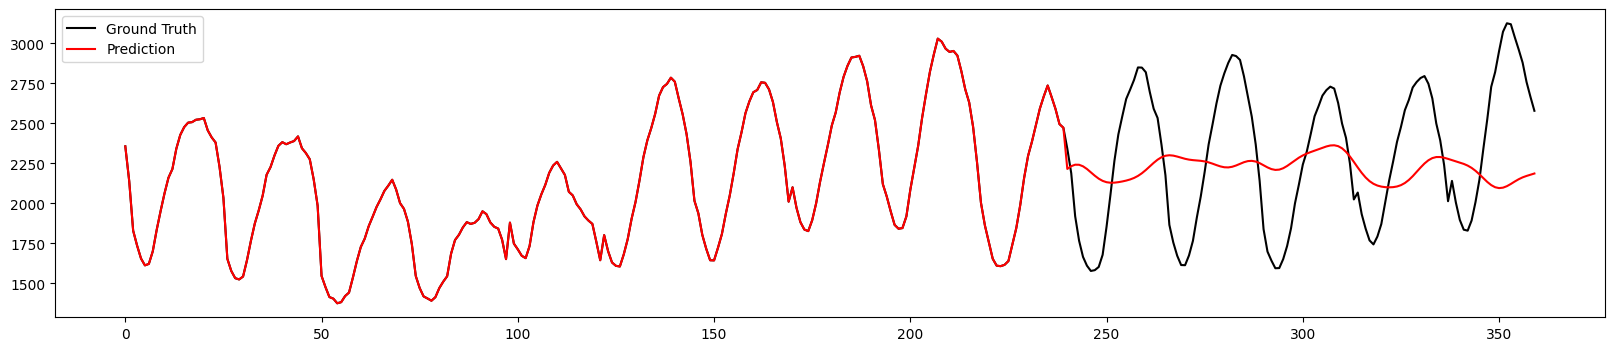

In [ ]:
model = torch.load("model.pth")


for _ in range(10):
    model.eval()
    samples, targets = next(val_generator)
    output = make_predictions(model, samples, targets.shape[1])
    print(output.shape)

    plot_predictions(header, samples, targets, output, mean, std)